In [2]:
data_dir= '/n/holylfs/LABS/wadduwage_lab/Lab/wadduwage-lab-data/Confocal/20200210_confocal-3d_Seeber-lab_h2ax-cells/63xZseriesSmall'

In [3]:
import glob
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage.filters
import torch
import shutil, os
import cv2

In [4]:
def clip_thres500(img):return np.clip(img, 0, 500)/500.0



def thresholding(img, upper_limit):
    B= 134.28
    img_clipped = (im_max < upper_limit).astype('float')
    img_norm= (img_clipped - img_clipped.min())/(img_clipped.max()- img_clipped.min())
    return img_norm

In [5]:
from kornia.morphology import dilation, erosion, opening, closing



In [6]:
def segment(images):
    kernel = torch.ones(10, 10)
    closed_images = closing((images > 0.33144).float(), kernel)
    return closed_images

In [7]:
#https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

def rmt(images_):
    out = []
    for images in images_:
        images= images[0].numpy() # remove channel dim
        images = gaussian_filter(images, 1)
        seed = np.copy(images)
        seed[1:-1, 1:-1] = images.min()
        mask = images

        dilated = reconstruction(seed, mask, method='dilation')
        h = 0.4
        seed = images - h
        dilated = reconstruction(seed, mask, method='dilation')
        hdome = images - dilated
        out.append(hdome)
    hdome= np.array(out)
    return torch.from_numpy(np.expand_dims(hdome, axis= 1))



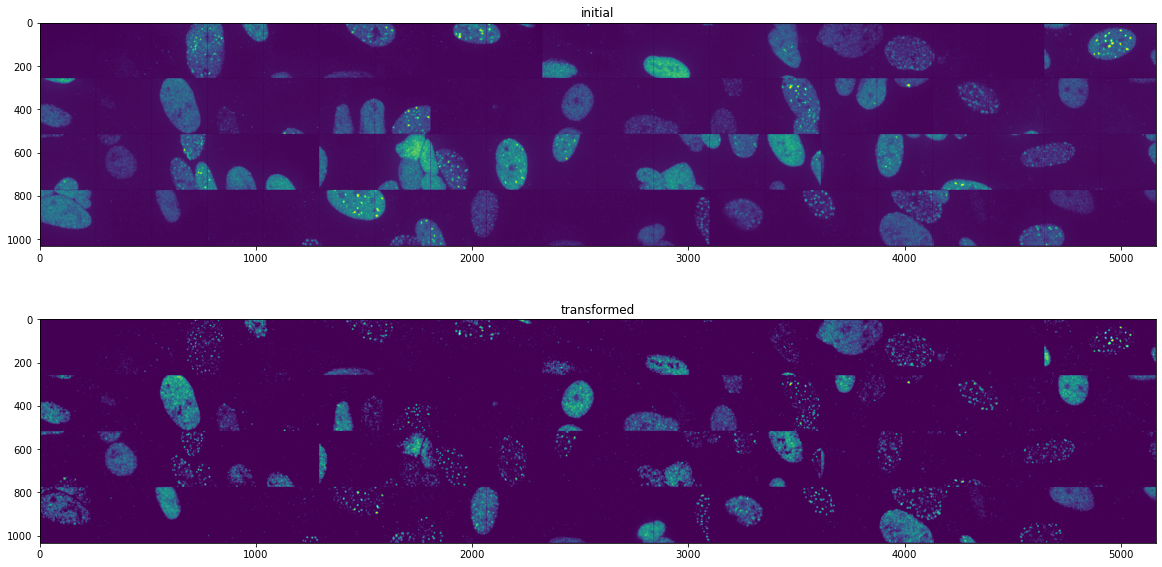

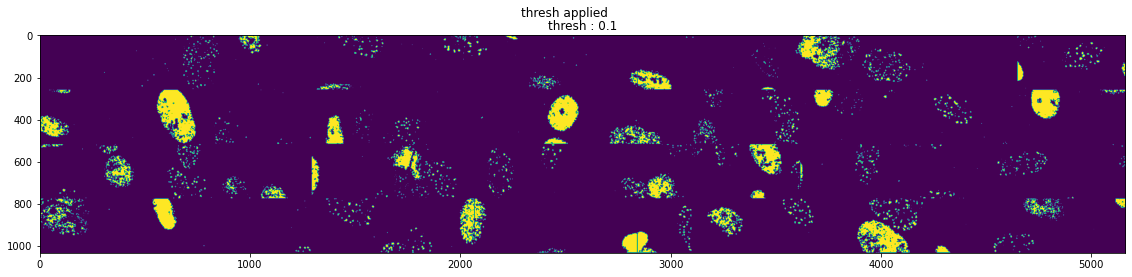

In [8]:
import cv2
import torchvision

kernel = torch.ones(10, 10)

def preprocess(img):
    B= 134.28
    clip_max= 800
    img_clipped = np.clip(im_max, B, clip_max) 
    img_norm= (img_clipped - B)/(clip_max- B)
    return img_norm

for w_idx in [1]:    
    sample_dirs =  sorted(glob.glob(f'{data_dir}/*_w{w_idx}*.stk'), key= lambda x: int(x.split('/')[-1][:-4].split('_')[-1][1:]))

    img= imread(sample_dirs[0])
    im_max= np.max(img, axis=0)
    im_max_filt= torch.from_numpy(preprocess(im_max).astype('float'))
    patch_size= 256

    patches_initial= im_max_filt.reshape(im_max_filt.shape[0]//patch_size, patch_size, im_max_filt.shape[0]//patch_size, patch_size).permute(0, 2, 1, 3).flatten(end_dim= 1)

    im_max_filt = rmt(im_max_filt.unsqueeze(dim=0).unsqueeze(dim=0))[0,0]

    patches= im_max_filt.reshape(im_max_filt.shape[0]//patch_size, patch_size, im_max_filt.shape[0]//patch_size, patch_size).permute(0, 2, 1, 3).flatten(end_dim= 1)

    initial_grid_img = torchvision.utils.make_grid(patches_initial[:80].unsqueeze(1), nrow=20)
    grid_img = torchvision.utils.make_grid(patches[:80].unsqueeze(1), nrow=20)

    plt.figure(figsize= (20, 10))
    plt.subplot(2, 1,  1)
    plt.imshow(cv2.cvtColor((initial_grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY))
    plt.title('initial')
    plt.subplot(2, 1,  2)
    plt.imshow(cv2.cvtColor((grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY))
    plt.title('transformed')
    plt.show()
    
    threshes= [0.1]
    plt.figure(figsize= (20, 4*len(threshes)))
    for i in range(len(threshes)):
        thresh= threshes[i]
        thres_patches = (patches > thresh).float()
        thres_grid_img = torchvision.utils.make_grid(thres_patches[:80].unsqueeze(1), nrow=20)

        plt.subplot(len(threshes), 1,  i+1)
        plt.imshow(cv2.cvtColor((thres_grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY))
        plt.title(f'thresh : {thresh}')
    plt.suptitle('thresh applied')
    plt.show()

In [9]:
def save_imgs_segmentation(sample_dirs, save_dir, patch_size= 256):
    try:shutil.rmtree(f'{save_dir}/seg_maps')
    except:pass

    try:shutil.rmtree(f'{save_dir}/images')
    except:pass

    os.mkdir(f'{save_dir}/seg_maps')
    os.mkdir(f'{save_dir}/images')
    
    for sample_dir in sample_dirs:
        img= imread(sample_dir)
        im_max= np.max(img, axis=0)
        im_max_filt= torch.from_numpy(preprocess(im_max).astype('float'))
        patches_initial= im_max_filt.reshape(im_max_filt.shape[0]//patch_size, patch_size, im_max_filt.shape[0]//patch_size, patch_size).permute(0, 2, 1, 3).flatten(end_dim= 1)
        im_max_filt = rmt(im_max_filt.unsqueeze(dim=0).unsqueeze(dim=0))[0,0]
        patches_segment= im_max_filt.reshape(im_max_filt.shape[0]//patch_size, patch_size, im_max_filt.shape[0]//patch_size, patch_size).permute(0, 2, 1, 3).flatten(end_dim= 1)
        
        for idx in range(len(patches)):
            patch_init = patches_initial[idx].numpy()
            patch_segment= patches_segment[idx].numpy()
            save_img_name = sample_dir.split('/')[-1][:-4]
            
            cv2.imwrite(f'{save_dir}/seg_maps/{save_img_name}_{idx}.png' , (255*patch_segment).astype('uint8'))
            cv2.imwrite(f'{save_dir}/images/{save_img_name}_{idx}.png' , (255*patch_init).astype('uint8'))
            
        type_ = save_dir.split('/')[-1]
        print(f'{type_} set -> saving : {save_dir}/*/{save_img_name}_{idx}.png')

In [10]:
def save_imgs_for_dataloaders_segment(stk_file_dirs, save_data_root_dir, type_, patch_size):
    save_dir= f'{save_data_root_dir}/{type_}'
    try:shutil.rmtree(save_dir)
    except:pass

    os.mkdir(save_dir)

    save_imgs_segmentation(stk_file_dirs, save_dir, patch_size= patch_size)

In [17]:
sample_dirs =  sorted(glob.glob(f'{data_dir}/*_w1*.stk'), key= lambda x: int(x.split('/')[-1][:-4].split('_')[-1][1:]))

save_data_root_dir= '/n/holyscratch01/wadduwage_lab/confocal_w1_segmentation_dataset'
#save_data_root_dir= './to_delete'

n_stk_files= len(sample_dirs)

sample_dirs[int(n_stk_files*0.9)]

'/n/holylfs/LABS/wadduwage_lab/Lab/wadduwage-lab-data/Confocal/20200210_confocal-3d_Seeber-lab_h2ax-cells/63xZseriesSmall/63X_IF4small_1_w1640bp_s190.stk'

In [ ]:
sample_dirs =  sorted(glob.glob(f'{data_dir}/*_w1*.stk'), key= lambda x: int(x.split('/')[-1][:-4].split('_')[-1][1:]))

#save_data_root_dir= '/n/holyscratch01/wadduwage_lab/confocal_w1_segmentation_dataset'
save_data_root_dir= './to_delete'

n_stk_files= len(sample_dirs)

#save_imgs_for_dataloaders_segment(sample_dirs[: int(n_stk_files*0.8)], save_data_root_dir, 'train', patch_size= 256)
#save_imgs_for_dataloaders_segment(sample_dirs[int(n_stk_files*0.8):int(n_stk_files*0.9)], save_data_root_dir, 'val', patch_size= 256)
#save_imgs_for_dataloaders_segment(sample_dirs[int(n_stk_files*0.9):], save_data_root_dir, 'test', patch_size= 256)

#save_imgs_for_dataloaders_segment(sample_dirs[0:2], save_data_root_dir, 'train', patch_size= 256)
#save_imgs_for_dataloaders_segment(sample_dirs[2:4], save_data_root_dir, 'val', patch_size= 256)
#save_imgs_for_dataloaders_segment(sample_dirs[4:6], save_data_root_dir, 'test', patch_size= 256)